In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from pandas.plotting import scatter_matrix

# Load the data
df = pd.read_csv('HVAC_NE_EC_19-21.csv', parse_dates=['Timestamp'])

# Set Timestamp as index
df.set_index('Timestamp', inplace=True)

# Display basic information and the first few rows to understand the structure
hvac_data_info = df.info()
hvac_data_head = df.head()

hvac_data_info, hvac_data_head

<class 'pandas.core.frame.DataFrame'>
Index: 33888 entries, 2019-10-15 00:00:00+02:00 to 2021-04-14 23:45:00+02:00
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   T_Supply      33888 non-null  float64
 1   T_Return      33888 non-null  float64
 2   SP_Return     33888 non-null  float64
 3   T_Saturation  33888 non-null  float64
 4   T_Outdoor     33888 non-null  float64
 5   RH_Supply     33888 non-null  float64
 6   RH_Return     33888 non-null  float64
 7   RH_Outdoor    33888 non-null  float64
 8   Energy        33888 non-null  float64
 9   Power         33888 non-null  float64
dtypes: float64(10)
memory usage: 2.8+ MB


(None,
                             T_Supply   T_Return  SP_Return  T_Saturation  \
 Timestamp                                                                  
 2019-10-15 00:00:00+02:00  19.859999  20.469999       18.5         19.02   
 2019-10-15 00:15:00+02:00  19.855000  20.430000       18.5         19.02   
 2019-10-15 00:30:00+02:00  19.850000  20.410000       18.5         19.02   
 2019-10-15 00:45:00+02:00  19.840000  20.379999       18.5         19.08   
 2019-10-15 01:00:00+02:00  19.830000  20.350000       18.5         19.08   
 
                            T_Outdoor  RH_Supply  RH_Return  RH_Outdoor  \
 Timestamp                                                                
 2019-10-15 00:00:00+02:00  20.299999  71.110001  58.919998        79.5   
 2019-10-15 00:15:00+02:00  20.299999  71.320000  59.000000        82.0   
 2019-10-15 00:30:00+02:00  20.299999  71.470001  59.109997        79.5   
 2019-10-15 00:45:00+02:00  20.299999  71.439995  59.309998        77.0   
 2

In [2]:
# Select features for anomaly detection
features = ['T_Supply', 'T_Return', 'SP_Return', 'T_Saturation', 'T_Outdoor', 
            'RH_Supply', 'RH_Return', 'RH_Outdoor', 'Energy', 'Power']

# Normalize the features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)

# Train Isolation Forest model
contamination = 0.1  #expected anomaly rate
clf = IsolationForest(contamination=contamination, random_state=42)
clf.fit(df_scaled)

# Predict anomalies
df['anomaly'] = clf.predict(df_scaled)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

# Calculate anomaly scores
df['anomaly_score'] = clf.decision_function(df_scaled)

# Print summary of anomalies
print(f"Total number of data points: {len(df)}")
print(f"Number of anomalies detected: {df['anomaly'].sum()}")
print(f"Percentage of anomalies: {df['anomaly'].mean()*100:.2f}%")

Total number of data points: 33888
Number of anomalies detected: 3389
Percentage of anomalies: 10.00%


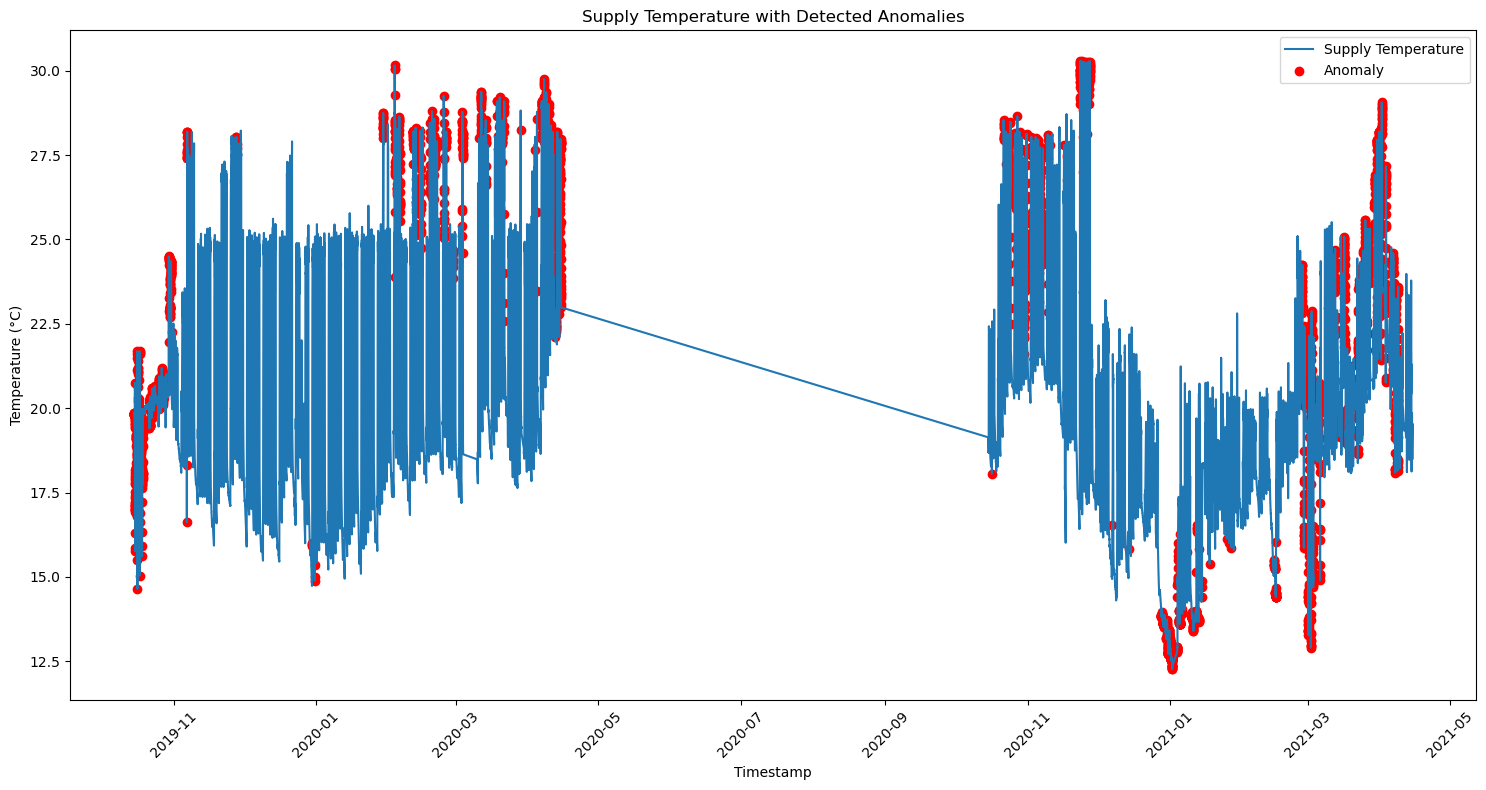

In [3]:
# Visualize anomalies
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['T_Supply'], label='Supply Temperature')
plt.scatter(df[df['anomaly'] == 1].index, df[df['anomaly'] == 1]['T_Supply'], color='red', label='Anomaly')
plt.title('Supply Temperature with Detected Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


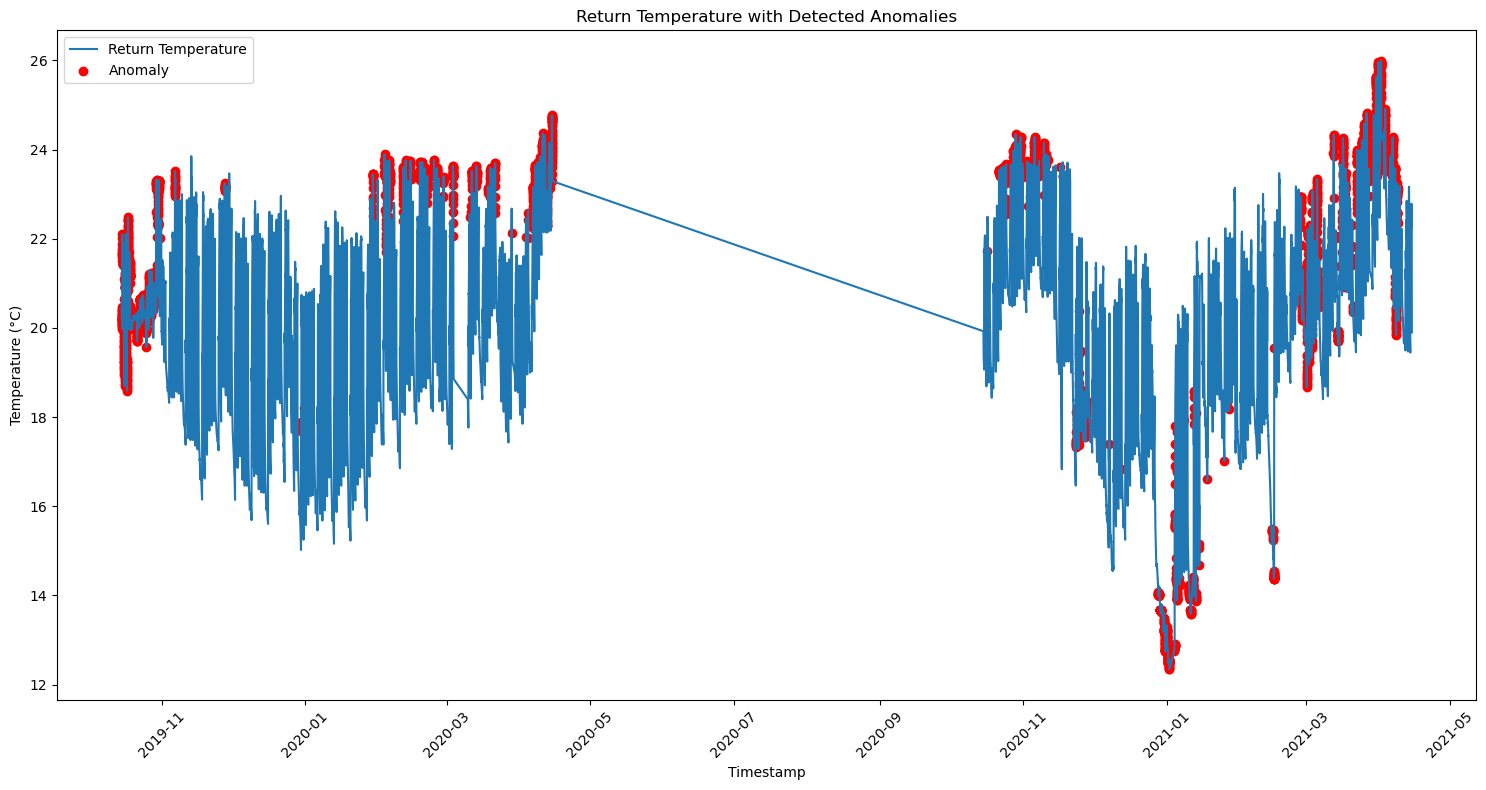

In [4]:
# Visualize anomalies
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['T_Return'], label='Return Temperature')
plt.scatter(df[df['anomaly'] == 1].index, df[df['anomaly'] == 1]['T_Return'], color='red', label='Anomaly')
plt.title('Return Temperature with Detected Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

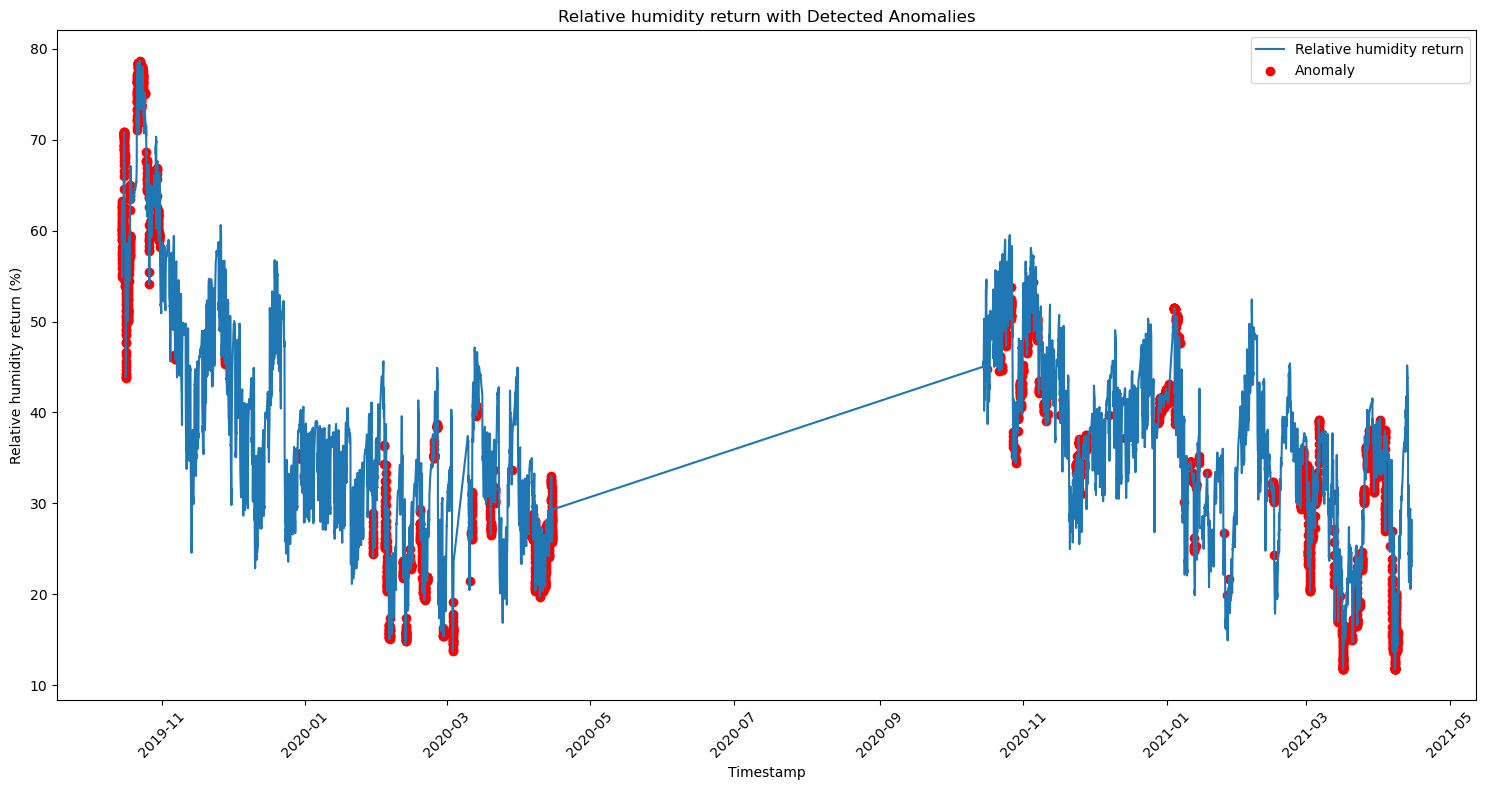

In [5]:
# Visualize anomalies
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['RH_Return'], label='Relative humidity return')
plt.scatter(df[df['anomaly'] == 1].index, df[df['anomaly'] == 1]['RH_Return'], color='red', label='Anomaly')
plt.title('Relative humidity return with Detected Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Relative humidity return (%)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

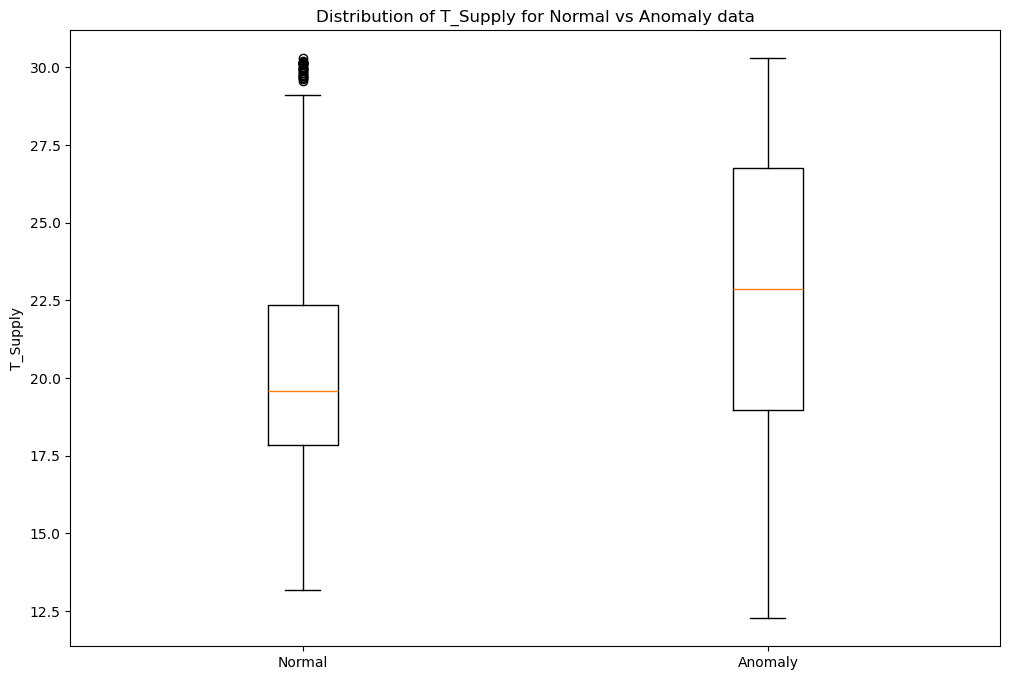

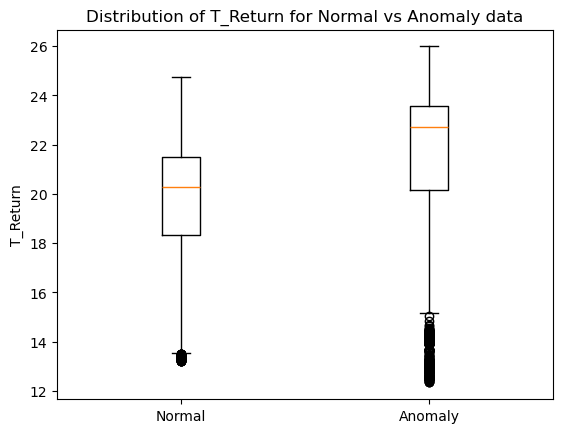

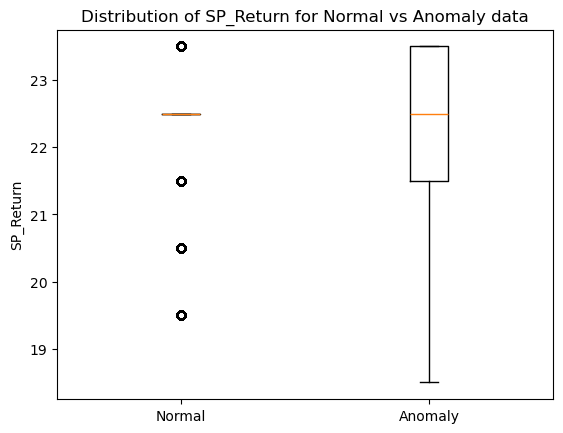

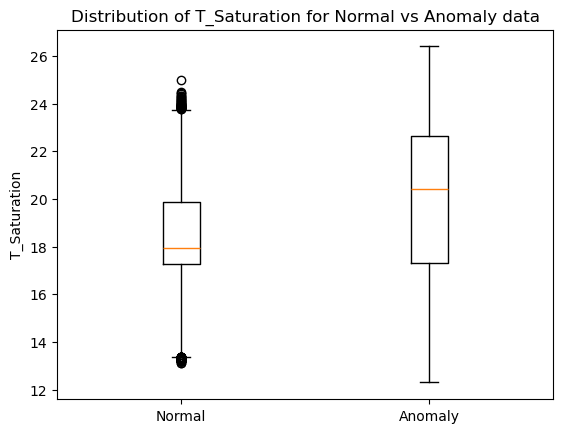

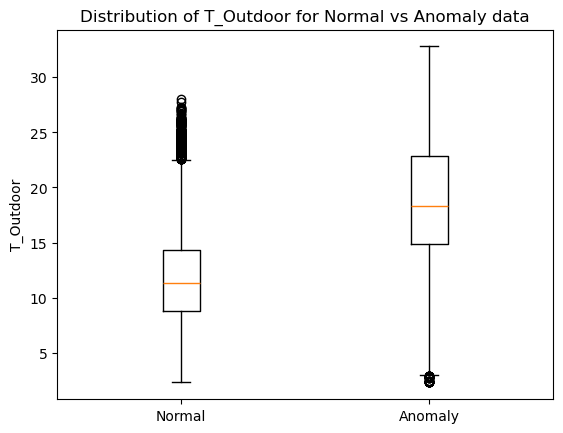

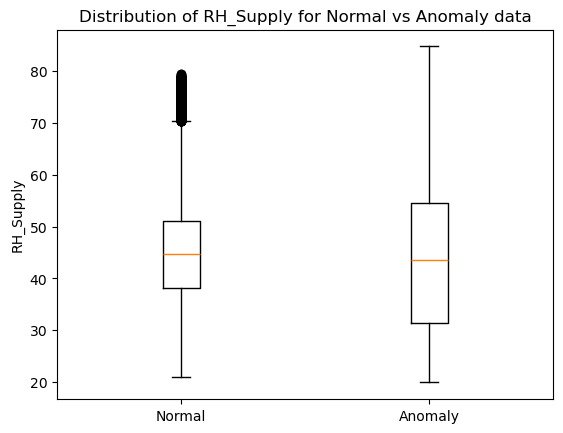

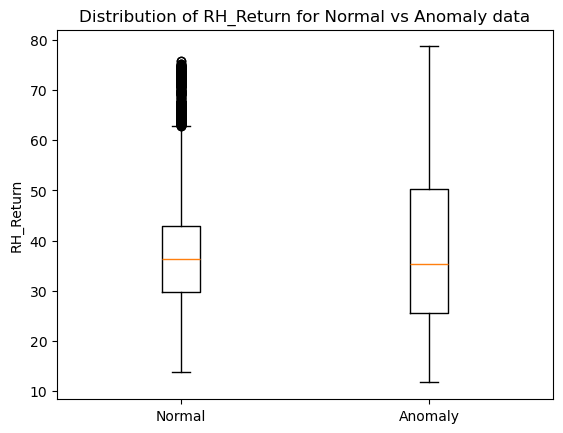

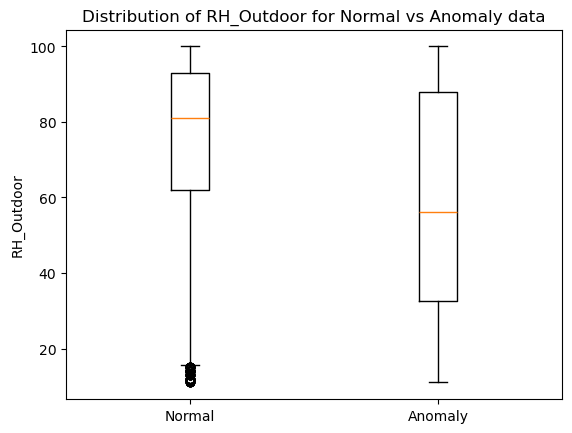

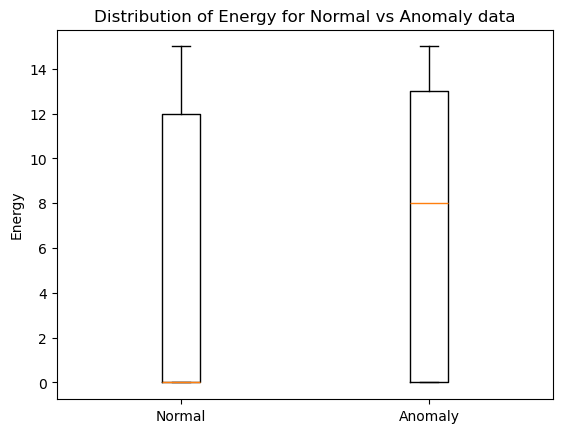

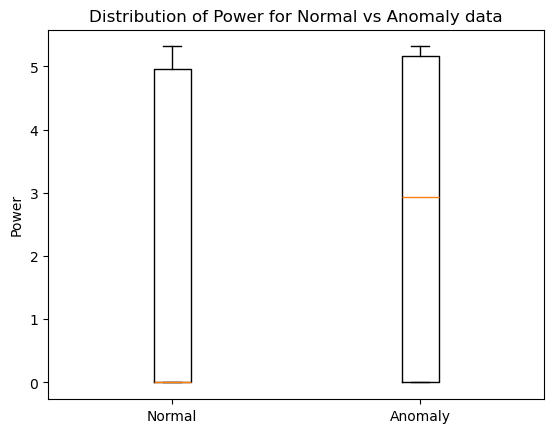

In [6]:
# Feature importance for anomalies
anomaly_data = df[df['anomaly'] == 1]
normal_data = df[df['anomaly'] == 0]

plt.figure(figsize=(12, 8))
for feature in features:
    plt.boxplot([normal_data[feature], anomaly_data[feature]], labels=['Normal', 'Anomaly'])
    plt.title(f'Distribution of {feature} for Normal vs Anomaly data')
    plt.ylabel(feature)
    plt.show()

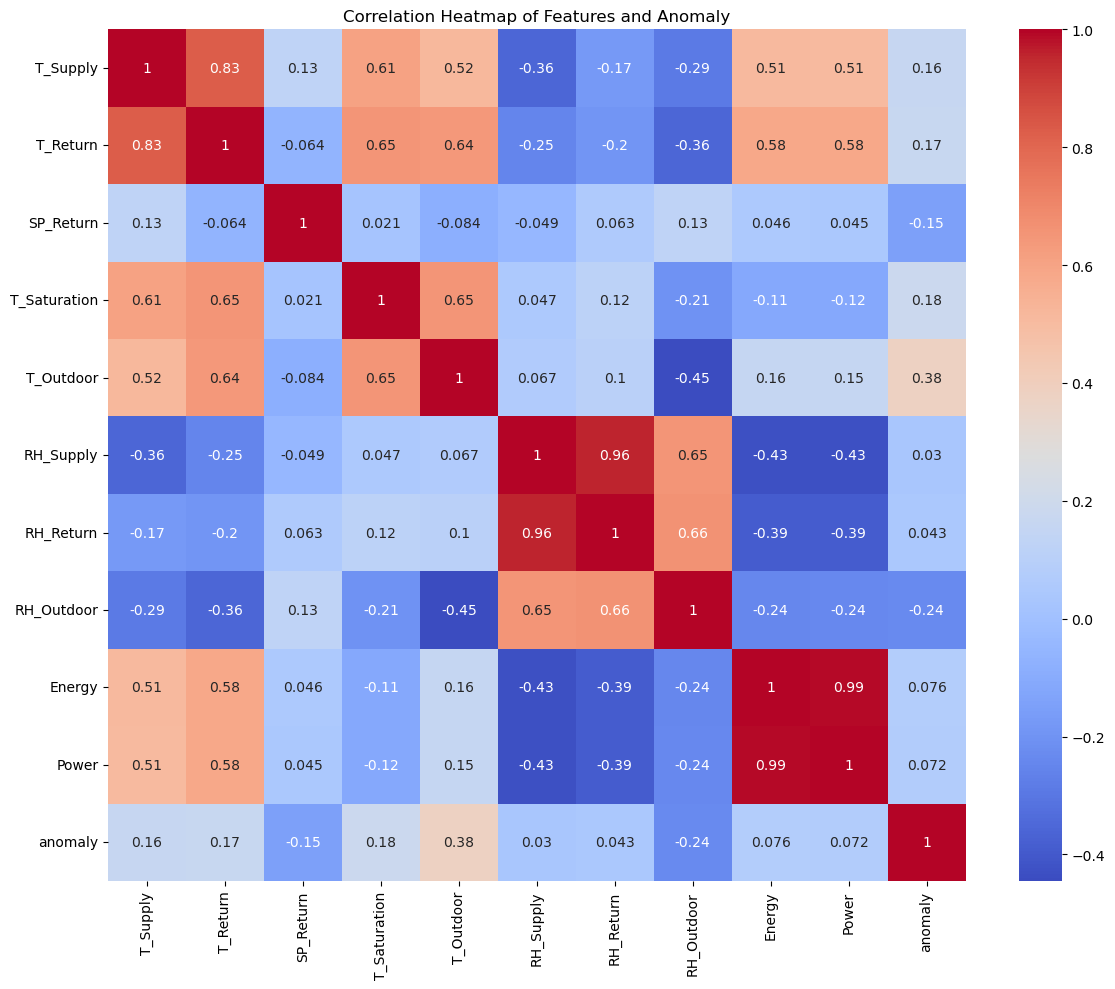

In [7]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[features + ['anomaly']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features and Anomaly')
plt.tight_layout()
plt.show()

In [8]:
# Function to calculate feature importance
def feature_importance(data, features):
    importance = {}
    for feature in features:
        importance[feature] = abs(data[data['anomaly'] == 1][feature].mean() - data[data['anomaly'] == 0][feature].mean())
    return pd.Series(importance).sort_values(ascending=False)

# Calculate and display feature importance
feature_imp = feature_importance(df, features)
print("Feature Importance for Anomalies:")
print(feature_imp)

Feature Importance for Anomalies:
RH_Outdoor      16.589762
T_Outdoor        6.287801
T_Supply         1.904094
RH_Return        1.628603
Energy           1.541663
T_Saturation     1.371415
T_Return         1.310481
RH_Supply        1.062600
Power            0.584255
SP_Return        0.370469
dtype: float64


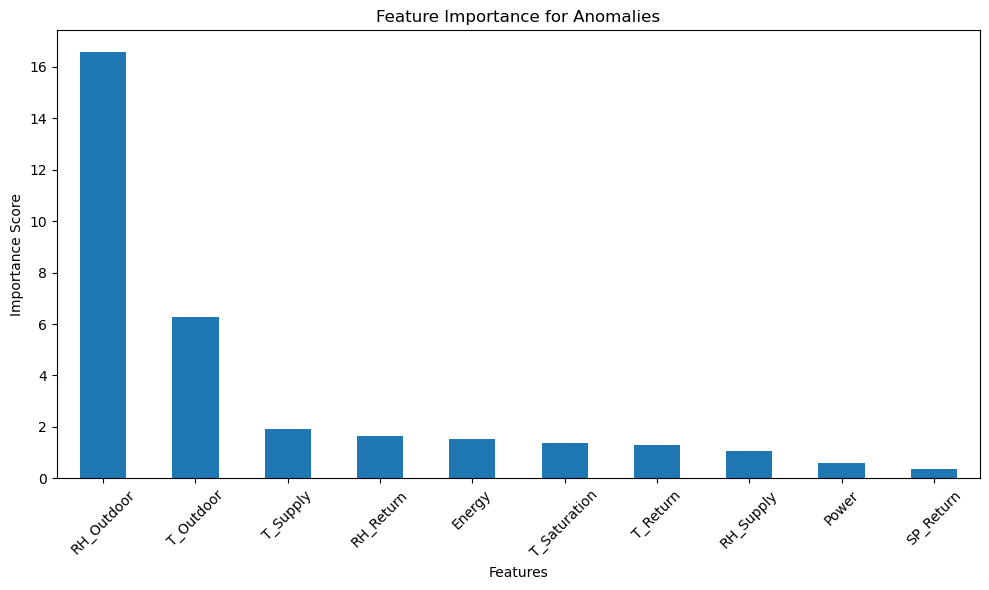

In [9]:
plt.figure(figsize=(10, 6))
feature_imp.plot(kind='bar')
plt.title('Feature Importance for Anomalies')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***HVAC Data Combinations and Their Insights***

### 1. Temperature Control

| **Data Combination**               | **Answer Provided**                                           |
| ---------------------------------- | ------------------------------------------------------------- |
| T_Supply vs T_Return               | Efficiency of heat exchange and distribution                  |
| T_Supply vs T_Outdoor              | System's ability to respond to outdoor temperature changes    |
| T_Saturation vs (T_Supply, T_Return) | Performance of cooling coil and dehumidification process       |

### 2. Humidity Control

| **Data Combination**               | **Answer Provided**                                           |
| ---------------------------------- | ------------------------------------------------------------- |
| RH_Supply vs RH_Return             | Effectiveness of moisture removal or addition                 |
| RH_Supply vs RH_Outdoor            | System's ability to control indoor humidity relative to outdoor conditions |

### 3. Energy Efficiency

| **Data Combination**               | **Answer Provided**                                           |
| ---------------------------------- | ------------------------------------------------------------- |
| Energy vs (T_Supply - T_Return)    | Energy efficiency of cooling/heating processes                |
| Power vs T_Outdoor                 | Appropriateness of power consumption relative to outdoor temperature |

### 4. System Performance

| **Data Combination**               | **Answer Provided**                                           |
| ---------------------------------- | ------------------------------------------------------------- |
| SP_Return vs T_Return              | System's ability to meet and maintain setpoint temperatures    |

### 5. Complex System Behavior

| **Data Combination**               | **Answer Provided**                                           |
| ---------------------------------- | ------------------------------------------------------------- |
| T_Supply, RH_Supply, Energy        | Overall system performance in managing temperature, humidity, and energy use |
| T_Outdoor, T_Supply, Power         | System's efficiency and response to varying outdoor conditions |

### 6. Time-Based Patterns

| **Data Combination**               | **Answer Provided**                                           |
| ---------------------------------- | ------------------------------------------------------------- |
| Any parameter vs Time of Day       | Daily patterns in system behavior and potential scheduling issues |
| Any parameter vs Day of Week       | Weekly patterns in system performance and occupancy-related effects |

### 7. Anomaly Detection

| **Data Combination**               | **Answer Provided**                                           |
| ---------------------------------- | ------------------------------------------------------------- |
| Any parameter vs Its Historical Range | Identification of unusual behavior in individual system components |
| Multiple parameters vs Their Expected Relationships | Detection of complex anomalies affecting multiple aspects of the system |

---

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the data using the structure above
data = [
    {"category": "Temperature Control", "combinations": [
        {"title": "T_Supply vs T_Return"},
        {"title": "T_Supply vs T_Outdoor"},
        {"title": "T_Saturation vs (T_Supply, T_Return)"}
    ]},
    {"category": "Humidity Control", "combinations": [
        {"title": "RH_Supply vs RH_Return"},
        {"title": "RH_Supply vs RH_Outdoor"}
    ]},
    {"category": "Energy Efficiency", "combinations": [
        {"title": "Energy vs (T_Supply - T_Return)"},
        {"title": "Power vs T_Outdoor"}
    ]},
    {"category": "System Performance", "combinations": [
        {"title": "SP_Return vs T_Return"}
    ]},
    {"category": "Complex System Behavior", "combinations": [
        {"title": "T_Supply, RH_Supply, Energy"},
        {"title": "T_Outdoor, T_Supply, Power"}
    ]},
    {"category": "Time-Based Patterns", "combinations": [
        {"title": "Any parameter vs Time of Day"},
        {"title": "Any parameter vs Day of Week"}
    ]},
    {"category": "Anomaly Detection", "combinations": [
        {"title": "Any parameter vs Its Historical Range"},
        {"title": "Multiple parameters vs Their Expected Relationships"}
    ]}
]

categories = [item['category'] for item in data]
combinations_count = [len(item['combinations']) for item in data]

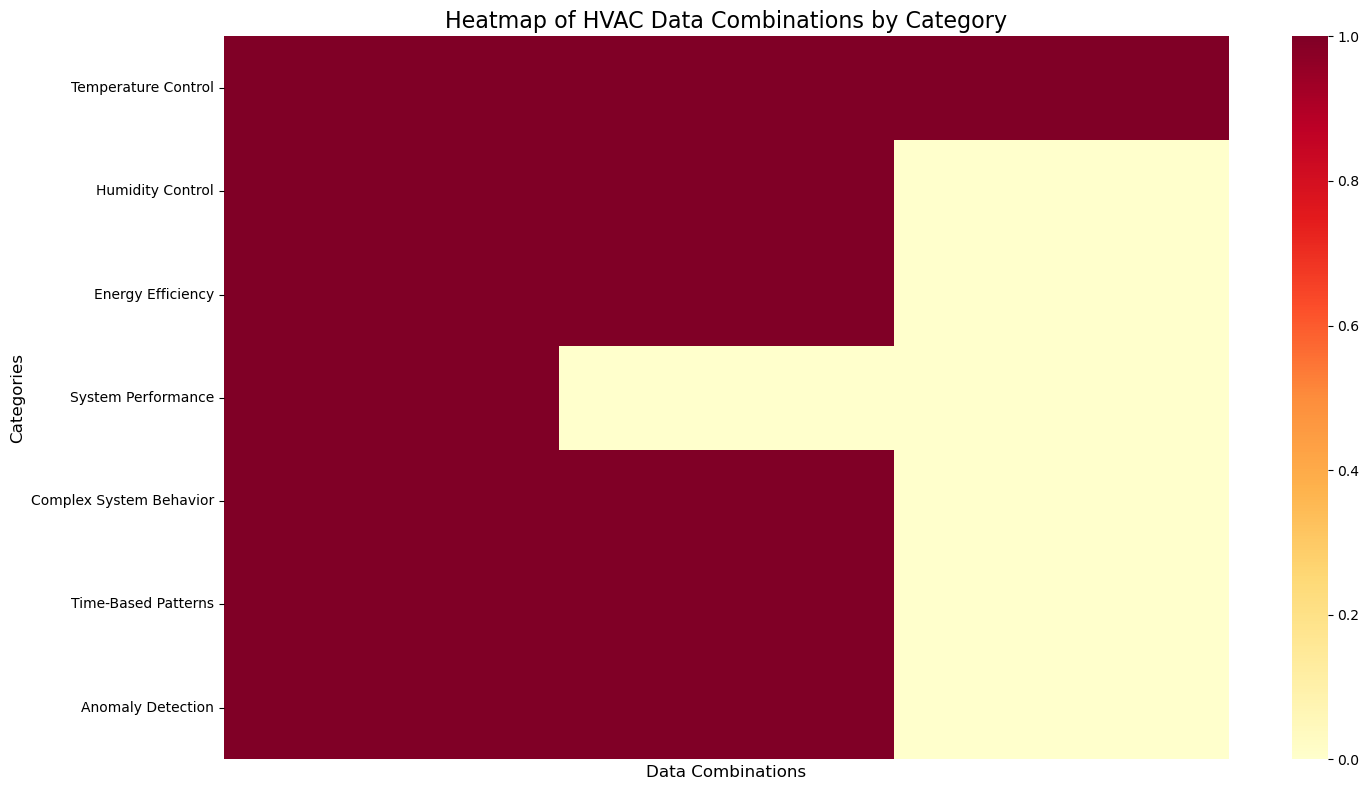

In [11]:
# Heatmap
combinations_matrix = np.zeros((len(categories), max(combinations_count)))
for i, item in enumerate(data):
    for j in range(len(item['combinations'])):
        combinations_matrix[i, j] = 1

plt.figure(figsize=(15, 8))
sns.heatmap(combinations_matrix, annot=False, cmap="YlOrRd", xticklabels=False, yticklabels=categories)
plt.title("Heatmap of HVAC Data Combinations by Category", fontsize=16)
plt.xlabel("Data Combinations", fontsize=12)
plt.ylabel("Categories", fontsize=12)
plt.tight_layout()
plt.show()

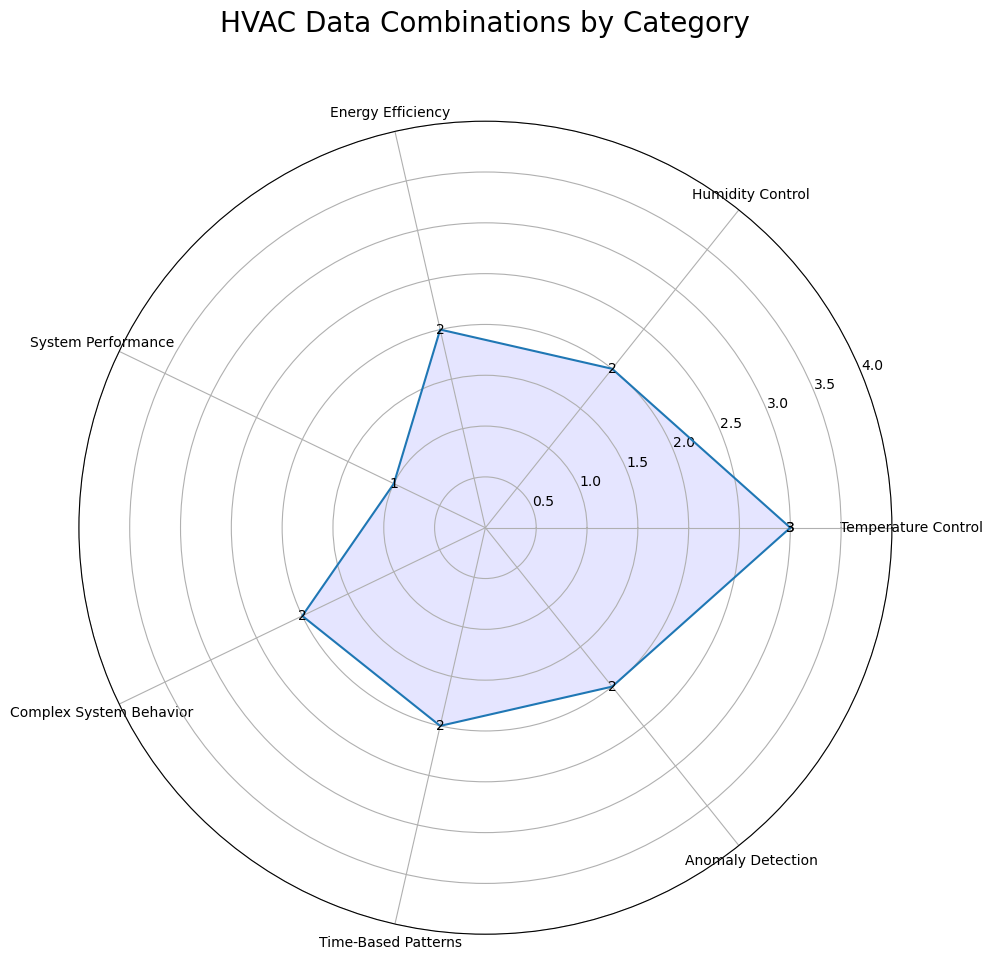

In [12]:
# Radar Chart
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], categories)

values = combinations_count + combinations_count[:1]
ax.plot(angles, values)
ax.fill(angles, values, 'b', alpha=0.1)

for angle, value in zip(angles, values):
    ax.text(angle, value, str(value), ha='center', va='center')

ax.set_ylim(0, max(combinations_count) + 1)

plt.title("HVAC Data Combinations by Category", size=20, y=1.1)
plt.tight_layout()
plt.show()

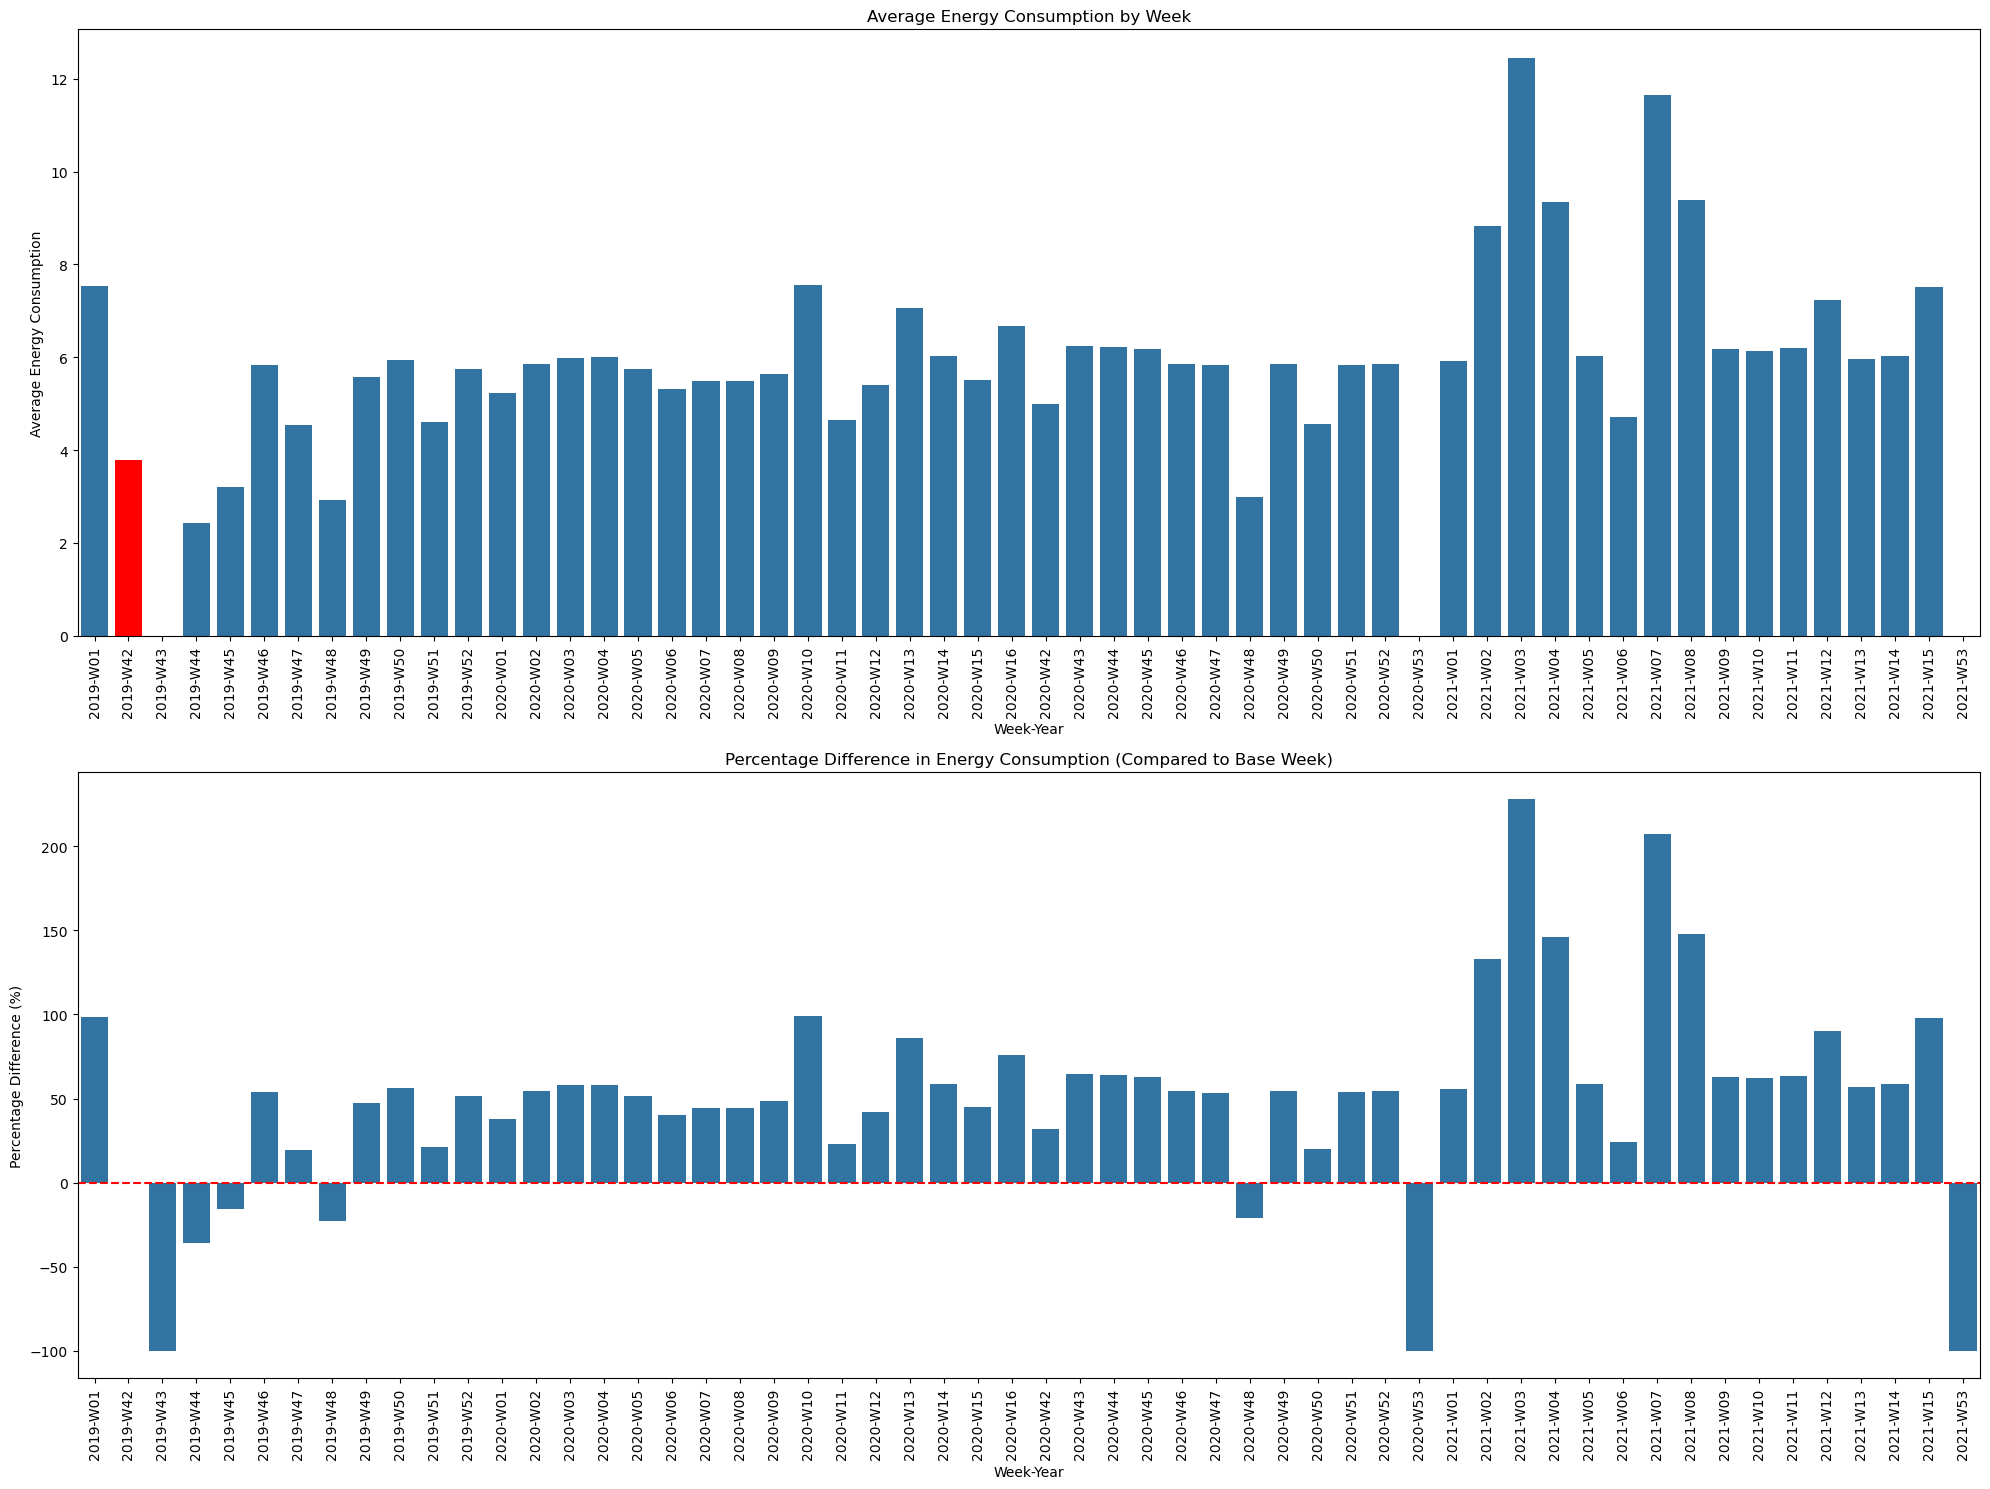

Summary Statistics:
       Average Energy  Percentage Difference
count       56.000000              56.000000
mean         5.709767              50.449498
std          2.237181              58.948591
min          0.000000            -100.000000
25%          5.167187              36.152790
50%          5.857887              54.352372
75%          6.193452              63.194354
max         12.441964             227.839498

Week with Highest Energy Consumption:
2021-W03 : 12.441964285714286

Week with Lowest Energy Consumption:
2019-W43 : 0.0

Week with Highest Percentage Difference:
2021-W03 : 227.8394981048229

Week with Lowest Percentage Difference:
2019-W43 : -100.0


In [13]:
# Function to get week number and year
def get_week_year(date):
    return f"{date.year}-W{date.isocalendar()[1]:02d}"

# Add week-year to the dataframe
df['Week_Year'] = df.index.map(get_week_year)

# Get the week-year for 2019-10-15
base_week_year = get_week_year(pd.Timestamp('2019-10-15'))

# Group by week-year and calculate average energy consumption
weekly_energy = df.groupby('Week_Year')['Energy'].mean()

# Calculate percentage difference from base week
base_energy = weekly_energy[base_week_year]
energy_diff = (weekly_energy - base_energy) / base_energy * 100

# Prepare data for plotting
plot_data = pd.DataFrame({
    'Average Energy': weekly_energy,
    'Percentage Difference': energy_diff
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 15))

# Plot average energy consumption
sns.barplot(x=plot_data.index, y='Average Energy', data=plot_data, ax=ax1)
ax1.set_title('Average Energy Consumption by Week')
ax1.set_xlabel('Week-Year')
ax1.set_ylabel('Average Energy Consumption')
ax1.tick_params(axis='x', rotation=90)

# Highlight base week
base_week_index = plot_data.index.get_loc(base_week_year)
ax1.patches[base_week_index].set_facecolor('red')

# Plot percentage difference
sns.barplot(x=plot_data.index, y='Percentage Difference', data=plot_data, ax=ax2)
ax2.set_title('Percentage Difference in Energy Consumption (Compared to Base Week)')
ax2.set_xlabel('Week-Year')
ax2.set_ylabel('Percentage Difference (%)')
ax2.axhline(y=0, color='r', linestyle='--')
ax2.tick_params(axis='x', rotation=90)

# Highlight base week
ax2.patches[base_week_index].set_facecolor('red')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary Statistics:")
print(plot_data.describe())

# Print weeks with highest and lowest energy consumption
print("\nWeek with Highest Energy Consumption:")
print(plot_data['Average Energy'].idxmax(), ":", plot_data['Average Energy'].max())
print("\nWeek with Lowest Energy Consumption:")
print(plot_data['Average Energy'].idxmin(), ":", plot_data['Average Energy'].min())

# Print weeks with highest and lowest percentage difference
print("\nWeek with Highest Percentage Difference:")
print(plot_data['Percentage Difference'].idxmax(), ":", plot_data['Percentage Difference'].max())
print("\nWeek with Lowest Percentage Difference:")
print(plot_data['Percentage Difference'].idxmin(), ":", plot_data['Percentage Difference'].min())